In [ ]:
from google.colab import drive,files
drive.mount('/content/drive')
os.makedirs("/content/5lsl0_MLSP")
ROOT_DIR = "/content/5lsl0_MLSP"
copy_tree("/content/5lsl0_MLSP","/content/drive/TUe/5lsl0_MLSP")

In [1]:
from Fast_MRI_dataloader import create_dataloaders
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from recreate import re_kspace

import torch.optim as optim
import torch.nn.functional as F

ROOT_DIR = os.path.abspath('.')
data_loc = os.path.join(ROOT_DIR,"Fast_MRI_Knee")
fig_loc = os.path.join(ROOT_DIR,"figure/week3")
batch_size = 5
train_loader, test_loader = create_dataloaders(data_loc,batch_size)
# train_loader,val_loader = torch.utils.data.random_split

if os.path.exists(fig_loc):
    pass
else:
    os.makedirs(fig_loc)

### 5b) ConvNet and loss plot

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet,self).__init__()
        self.convnet = nn.Sequential(
            nn.Conv2d(1,8,3,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8,16,3,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,8,3,padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8,1,3,padding=1)
        )
    def forward(self,x):
        if x.dim == 3:
            x = x.reshape((x.shape[0],1,x.shape[1],x.shape[2]))
        # x = torch.abs(x)
        x = self.convnet(x)
        return x

In [3]:
# train set up
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 1e-4
no_epochs = 10
# model ConvNet
model_convnet = ConvNet().to(device)
optimizer_convnet =  optim.Adam(model_convnet.parameters(),lr = learning_rate)
loss_train_epoch = []
loss_test_epoch = []
torch.random.manual_seed(0)

In [14]:
# training
print(f'Training on {device}')
for epoch in tqdm(range(no_epochs),colour='green'):
    print(f'Epoch[{epoch+1}/{no_epochs}]')
    total_loss = 0
    model_convnet.train()
    for batch_idx,(kp,m,gt) in enumerate(train_loader):
        optimizer_convnet.zero_grad()
        inputs = torch.abs(re_kspace(kp)).to(device=device)
        re = model_convnet(inputs).reshape((batch_size,320,320))
        loss = F.mse_loss(re,gt)
        loss.backward()
        optimizer_convnet.step()
        # loss_train_epoch.append(loss.item())
        total_loss += loss.item()
    loss_train_epoch.append(total_loss/len(train_loader))
    print(f'Loss(Train):{total_loss/len(train_loader)}')
    total_loss = 0
    model_convnet.eval()
    for _,(kp,m,gt) in enumerate(test_loader):
        inputs = torch.abs(re_kspace(kp)).to(device=device)
        re = model_convnet(inputs).reshape((batch_size,320,320))
        loss = F.mse_loss(re,gt)
        total_loss += loss.item()
    loss_test_epoch.append(total_loss/len(test_loader))
    print(f'Loss(Test):{total_loss/len(test_loader)}')
    


  0%|          | 0/10 [00:00<?, ?it/s]

Training on cpu
Epoch[1/10]
Loss(Train):0.2933629710972309


 10%|█         | 1/10 [00:59<08:54, 59.42s/it]

Loss(Test):0.11211918689766709
Epoch[2/10]
Loss(Train):0.06759247456987699


 20%|██        | 2/10 [01:52<07:40, 57.60s/it]

Loss(Test):0.029414419845050693
Epoch[3/10]
Loss(Train):0.028076522015035153


 30%|███       | 3/10 [02:42<06:26, 55.15s/it]

Loss(Test):0.018998156282670643
Epoch[4/10]
Loss(Train):0.022833601646125315


 40%|████      | 4/10 [03:31<05:20, 53.46s/it]

Loss(Test):0.01719133768762861
Epoch[5/10]
Loss(Train):0.021861063664158187


 50%|█████     | 5/10 [04:22<04:23, 52.72s/it]

Loss(Test):0.016541325658255696
Epoch[6/10]
Loss(Train):0.021054075670739015


 60%|██████    | 6/10 [05:11<03:25, 51.48s/it]

Loss(Test):0.01605995776777973
Epoch[7/10]
Loss(Train):0.0207127949471275


 70%|███████   | 7/10 [06:02<02:34, 51.42s/it]

Loss(Test):0.01569526631157009
Epoch[8/10]
Loss(Train):0.020166636587431033


 80%|████████  | 8/10 [06:54<01:43, 51.53s/it]

Loss(Test):0.015472420472271589
Epoch[9/10]
Loss(Train):0.019977005639423926


 90%|█████████ | 9/10 [07:46<00:51, 51.69s/it]

Loss(Test):0.015207875500984338
Epoch[10/10]
Loss(Train):0.01956281860669454


100%|██████████| 10/10 [08:38<00:00, 51.86s/it]

Loss(Test):0.015038305551421886


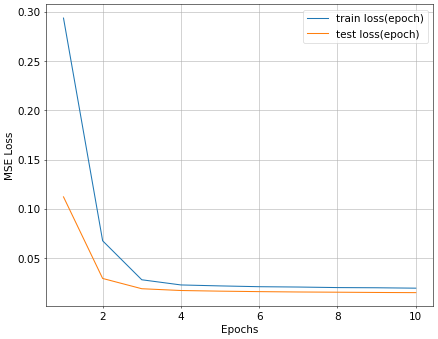

In [15]:
# Plot the train loss and test loss
plt.figure(figsize=(10,8),dpi=50,facecolor='w',edgecolor='k')
plt.plot(range(1,no_epochs+1),loss_train_epoch,label='train loss(epoch)',linestyle='-')
plt.plot(range(1,no_epochs+1),loss_test_epoch,label='test loss(epoch)',linestyle='-')
plt.legend(loc=1,prop={'size': 15})
plt.xlabel("Epochs",fontdict={'size':15})
plt.ylabel("MSE Loss",fontdict={'size':15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.savefig(os.path.join(fig_loc,"w3e3_loss_plot.png"),dpi=50,bbox_inches='tight')
plt.show()

### 5c)

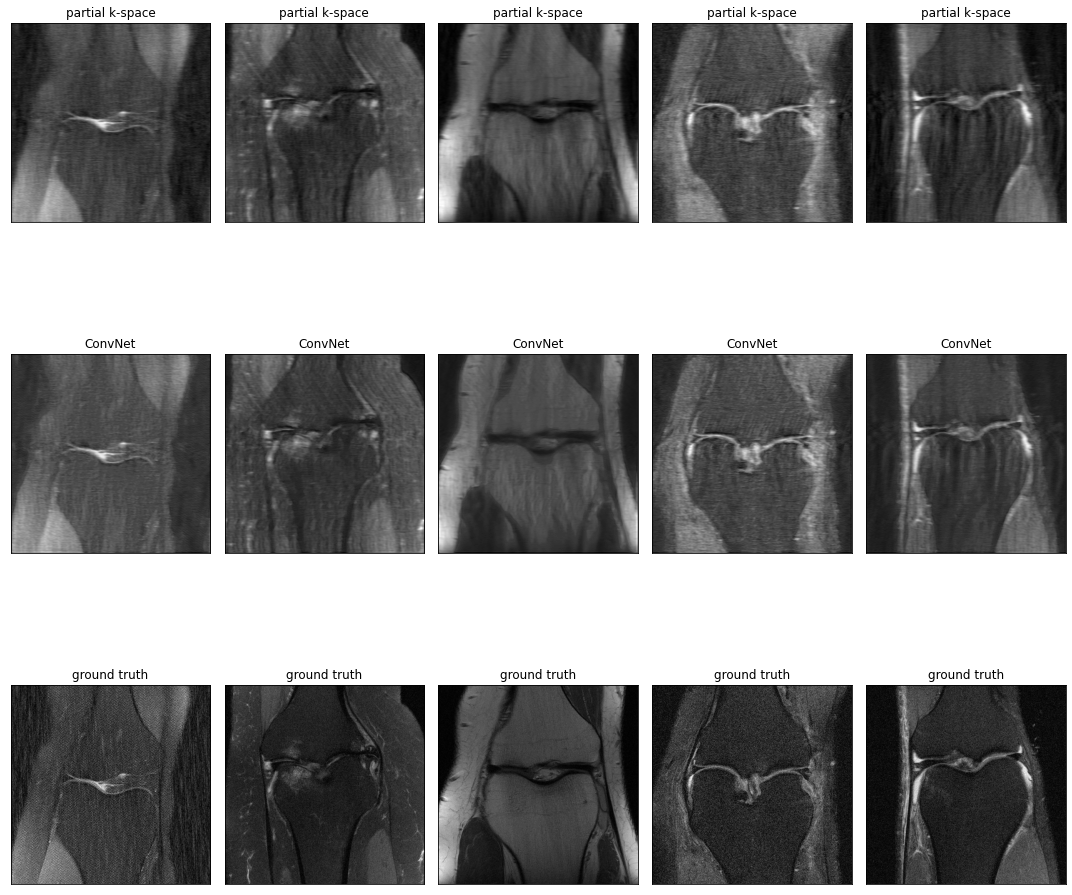

In [16]:

kp,m,gt = next(iter(test_loader))

plt.figure(figsize=(15,15))
for ii in range(batch_size):
    gt_re = torch.abs(re_kspace(kp[ii,:,:]))
    # print(gt_re.shape)
    gt_convnet_re = model_convnet(gt_re.reshape(1,320,320)).detach()
    plt.subplot(3,5,1+ii)
    plt.imshow(gt_re,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title("partial k-space")
    plt.subplot(3,5,6+ii)
    plt.imshow(gt_convnet_re.reshape((320,320)),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title("ConvNet")
    plt.subplot(3,5,11+ii)
    plt.imshow(gt[ii,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title("ground truth")

plt.tight_layout()
plt.savefig(os.path.join(fig_loc,"w3e5qc.png"),dpi=80,bbox_inches='tight')
plt.show()

### 5d) MSE 

In [17]:
import sys
from tqdm import tqdm
import torch.nn.functional as F

MSE=0
for batch_idx,(kp,m,gt) in enumerate(tqdm(test_loader,colour='green')):
    inputs = torch.abs(re_kspace(kp)).to(device=device)
    outputs = model_convnet(inputs).reshape((batch_size,320,320))
    MSE += F.mse_loss(gt,outputs)

print(f'MSE over whole test set is {MSE/(batch_idx+1)}')

100%|██████████| 49/49 [00:13<00:00,  3.70it/s]

MSE over whole test set is 0.015038303099572659


In [18]:
model_loc = os.path.join(os.path.abspath("."),"model")
torch.save(model_convnet,os.path.join(model_loc,"convnet.ptg"))

### Exercise 6

In [4]:
class NPGD_unit(nn.Module):
    def __init__(self,M,mu):
        super().__init__()
        self.M = M
        self.mu = mu
        self.operator = ConvNet()
    def forward(self,y,x):
        y_ = self.mu * y
        x_ = x @ (torch.eye(y.shape[-1]).to(device=device) - self.mu * \
            torch.abs(re_kspace(self.M.T)@re_kspace(self.M)).to(device=device))
        x_ = self.operator(y_ + x_)
        return x_

class NPGD(nn.Module):
    def __init__(self,K,M,mu):
        super().__init__()
        self.K = K
        self.M = M
        self.mu = mu
        self.list = nn.ModuleList(NPGD_unit(self.M,self.mu) for _ in range(self.K))
    def forward(self,y):
        if y.dim() == 3:
            y=y.reshape((y.shape[0],1,y.shape[-2],y.shape[-1]))
        x = torch.zeros_like(y).to(device=device)
        for m in self.list:
            x = m(y,x)
        return x

In [21]:
y = torch.ones((5,1,320,320))
x = torch.zeros_like(y).to(device=device)
x_ = x @ (torch.eye(y.shape[-1]).to(device=device) - 0.5 * \
            torch.abs(re_kspace(M.T)@re_kspace(M)).to(device=device))
# (torch.eye(y.shape[-1]).to(device=device)-torch.abs(re_kspace(torch.permute(M,(0,1,3,2)))@re_kspace(M))).shape
x_.dim()

4

In [5]:
mu = 0.6
K = 5
_,M,_ = next(iter(train_loader))
M = M[0,:,:]
# train set up
device = "cuda" if torch.cuda.is_available() else "cpu"
learning_rate = 1e-4
no_epochs = 10

model_NPGD = NPGD(K,M,mu).to(device)
optimizer_NPGD =  optim.Adam(model_NPGD.parameters(),lr = learning_rate)
loss_train_epoch = []
loss_test_epoch = []
torch.random.manual_seed(0)

In [23]:
# training
print(f'Training on {device}')
for epoch in tqdm(range(no_epochs),colour='green'):
    print(f'Epoch[{epoch+1}/{no_epochs}]')
    total_loss = 0
    model_NPGD.train()
    for batch_idx,(kp,m,gt) in enumerate(train_loader):
        optimizer_NPGD.zero_grad()
        inputs = torch.abs(re_kspace(kp)).to(device=device)
        # print(inputs.dim())
        re = model_NPGD(inputs).reshape((batch_size,320,320))
        loss = F.mse_loss(re,gt)
        loss.backward()
        optimizer_NPGD.step()
        # loss_train_epoch.append(loss.item())
        total_loss += loss.item()
    loss_train_epoch.append(total_loss/len(train_loader))
    print(f'Loss(Train):{total_loss/len(train_loader)}')
    total_loss = 0
    model_NPGD.eval()
    for _,(kp,m,gt) in enumerate(test_loader):
        inputs = torch.abs(re_kspace(kp)).to(device=device)
        re = model_NPGD(inputs).reshape((batch_size,320,320))
        loss = F.mse_loss(re,gt)
        total_loss += loss.item()
    loss_test_epoch.append(total_loss/len(test_loader))
    print(f'Loss(Test):{total_loss/len(test_loader)}')
    


  0%|          | 0/10 [00:00<?, ?it/s]

Training on cpu
Epoch[1/10]
Loss(Train):0.15281362533569337


 10%|█         | 1/10 [03:46<33:58, 226.48s/it]

Loss(Test):0.03548226813424607
Epoch[2/10]
Loss(Train):0.032208049210409324


 20%|██        | 2/10 [07:56<31:08, 233.60s/it]

Loss(Test):0.022918294259936224
Epoch[3/10]
Loss(Train):0.026114862921337287


 30%|███       | 3/10 [12:14<28:06, 240.99s/it]

Loss(Test):0.020229276041595304
Epoch[4/10]
Loss(Train):0.0237918862203757


 40%|████      | 4/10 [16:28<24:28, 244.72s/it]

Loss(Test):0.019085886356021677
Epoch[5/10]
Loss(Train):0.022371440641582013


 50%|█████     | 5/10 [20:33<20:24, 244.95s/it]

Loss(Test):0.017575483198980897
Epoch[6/10]
Loss(Train):0.021387707528968652


 60%|██████    | 6/10 [24:43<16:25, 246.37s/it]

Loss(Test):0.01696991207724323
Epoch[7/10]
Loss(Train):0.020660967354973157


 70%|███████   | 7/10 [28:47<12:17, 245.76s/it]

Loss(Test):0.016412360422617317
Epoch[8/10]
Loss(Train):0.02010781245927016


 80%|████████  | 8/10 [32:32<07:58, 239.29s/it]

Loss(Test):0.016046596538959717
Epoch[9/10]
Loss(Train):0.019635321429620187


 90%|█████████ | 9/10 [36:21<03:56, 236.43s/it]

Loss(Test):0.015727659155215536
Epoch[10/10]
Loss(Train):0.01925962115948399


100%|██████████| 10/10 [40:05<00:00, 240.54s/it]

Loss(Test):0.015456758040402616


In [6]:
model_loc = os.path.join(os.path.abspath("."),"model")
# torch.save(model_NPGD,os.path.join(model_loc,"proxnet.ptg"))
# del model_NPGD
model_NPGD = torch.load(os.path.join(model_loc,"proxnet.ptg"))

In [25]:
# check if the sampling mask is all the same or not
m_diff = []
for _ in range(15):
    _,m1,_ = next(iter(test_loader))
    _,m2,_ = next(iter(train_loader))
    m_diff.append(torch.sum(m1-m2))
sum(m_diff)
# m1.permute(0,1,3,2)
m1.dim()

3

In [26]:
# test for tensor @ multiplication
import torch
a = torch.ones((2,3))

b = torch.ones((3,1,3,2))
(a@b).shape

torch.Size([3, 1, 2, 2])

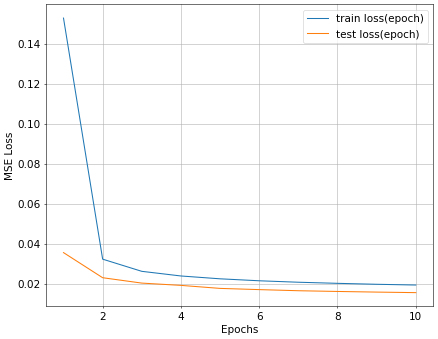

In [27]:
# plot loss
# Plot the train loss and test loss
plt.figure(figsize=(10,8),dpi=50,facecolor='w',edgecolor='k')
plt.plot(range(1,no_epochs+1),loss_train_epoch,label='train loss(epoch)',linestyle='-')
plt.plot(range(1,no_epochs+1),loss_test_epoch,label='test loss(epoch)',linestyle='-')
plt.legend(loc=1,prop={'size': 15})
plt.xlabel("Epochs",fontdict={'size':15})
plt.ylabel("MSE Loss",fontdict={'size':15})
plt.xticks(size=15)
plt.yticks(size=15)
plt.grid()
plt.savefig(os.path.join(fig_loc,"w3e6_loss_plot.png"),dpi=50,bbox_inches='tight')
plt.show()

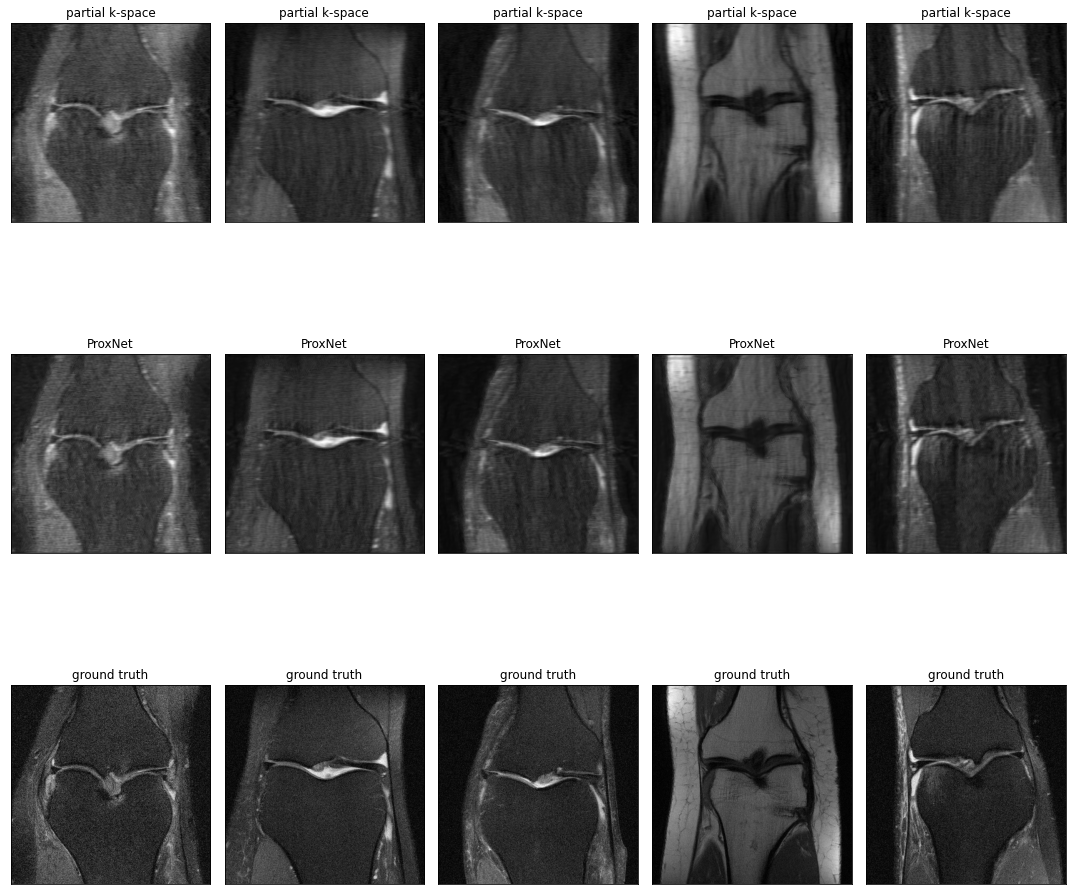

In [28]:
# plot examples

kp,m,gt = next(iter(test_loader))

plt.figure(figsize=(15,15))
for ii in range(batch_size):
    gt_re = torch.abs(re_kspace(kp[ii,:,:]))
    # print(gt_re.shape)
    # gt_convnet_re = model_convnet(gt_re.reshape(1,320,320)).detach()
    re = model_NPGD(gt_re.reshape(1,320,320)).detach()
    plt.subplot(3,5,1+ii)
    plt.imshow(gt_re,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title("partial k-space")
    plt.subplot(3,5,6+ii)
    plt.imshow(re.reshape((320,320)),cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title("ProxNet")
    plt.subplot(3,5,11+ii)
    plt.imshow(gt[ii,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title("ground truth")

plt.tight_layout()
plt.savefig(os.path.join(fig_loc,"w3e6qd.png"),dpi=80,bbox_inches='tight')
plt.show()

In [7]:
# 6d) MSE loss

import sys
from tqdm import tqdm
import torch.nn.functional as F

MSE=0
for batch_idx,(kp,m,gt) in enumerate(tqdm(test_loader,colour='green')):
    inputs = torch.abs(re_kspace(kp)).to(device=device)
    outputs = model_NPGD(inputs).reshape((batch_size,320,320))
    MSE += F.mse_loss(gt,outputs)
    del kp,m,gt,inputs,outputs

print(f'MSE over whole test set is {MSE/(batch_idx+1)}')

100%|██████████| 49/49 [01:11<00:00,  1.45s/it]

MSE over whole test set is 0.015456756576895714
